Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

# Introduction: Home Credit Default Risk Competition
-----------------

## Data

Les données sont fournies par [Home Credit] (http://www.homecredit.net/about-us.aspx), un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou s'il rencontrera des difficultés est un besoin commercial essentiel, et Home Credit organise ce concours sur Kaggle pour voir quel type de modèles la communauté de l'apprentissage automatique peut développer pour l'aider dans cette tâche. 

Il existe 7 sources de données différentes :


* **application_train/application_test**: the main training and testing data avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données du train sont accompagnées de la  `TARGET` qui indique 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé. 
* **bureau**: les données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
* **bureau_balance**: données mensuelles sur les crédits antérieurs dans le bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit. 
* **previous_application**: les demandes de crédit antérieures auprès de Home Credit. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique `SK_ID_PREV`. 
* **POS_CASH_BALANCE**: des données mensuelles sur les prêts au point de vente ou au comptant que les clients ont contractés auprès de Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
* **credit_card_balance**: des données mensuelles sur les cartes de crédit que les clients ont eues précédemment avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installments_payment** l'historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué. 



Voir schéma tables pour assemblage : "C:\Users\belou\Projet 7\input\schéma_tables.png"
Voir dico variables : "C:\Users\belou\Projet 7\input\dico_variables.xlsx"

## Metric: ROC AUC

La mesure de classification courante utilisée c'est la COURBE ROC :

https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it
https://en.wikipedia.org/wiki/Receiver_operating_characteristic
https://darwin.unmc.edu/dxtests/roc3.htm


Lorsqu'on mesure une classification en fonction de l'AUC, on ne génère pas des prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut être déroutant car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je me contenterais de créer un modèle prédisant que chaque personne n'est pas un terroriste. Il est clair que cela ne serait pas efficace (le rappel serait nul) et nous utilisons des mesures plus avancées telles que la SSC ROC ou le score F1 pour refléter plus précisément les performances d'un classificateur. 

https://en.wikipedia.org/wiki/F-score

Un modèle ayant un ROC AUC élevé aura également une grande précision, mais l'AUC est une meilleure représentation de la performance du modèle.

https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy


# 1 - Train / test
--------------

Dans ce NB, nous nous en tiendrons à utiliser uniquement les données d'entraînement et de test de l'application principale. Bien que nous devions utiliser toutes les données si nous voulions avoir un espoir de rivaliser sérieusement, nous nous en tiendrons pour l'instant à un seul fichier, ce qui devrait être plus facile à gérer. Cela nous permettra d'établir une base de référence que nous pourrons ensuite améliorer. Dans ce genre de projet, il est préférable de comprendre le problème petit à petit plutôt que de s'y plonger complètement et de s'y perdre ! 

## 1.1 - Imports


In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from mlflow.models import infer_signature


## 1.2 - Read in Data 

In [2]:
# List files available
print(os.listdir("../input/"))

['.ipynb_checkpoints', '1 - start-here-a-gentle-introduction.ipynb', '2 - with set de validation et création de métrique.ipynb', '3 - train_test__features_metier.ipynb', 'application_test.csv', 'application_train.csv', 'baseline_lgb.csv', 'baseline_lgb_domain_features.csv', 'bureau.csv', 'bureau_balance.csv', 'columns_description.ipynb', 'credit_card_balance.csv', 'dico_train_test.csv', 'dico_variables.xlsx', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'log_reg_baseline.csv', 'methodo.xlsx', 'POS_CASH_balance.csv', 'previous_application.csv', 'random_forest_baseline.csv', 'random_forest_baseline_domain.csv', 'random_forest_baseline_engineered.csv', 'sample_submission.csv', 'schéma_tables.png', 'start-here-a-gentle-introduction.ipynb', '~$methodo.xlsx']


In [3]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Le train comporte 307511 observations (chacune étant un prêt distinct) et 122 variables, y compris la target

In [4]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le test comporte bcp moins d'observations (48744) et ne comporte pas de  TARGET. Nous n'en tiendrons pas compte dans un 1er temps

## 1.3 - Exploratory Data Analysis

### 1.3.1 -  Distribution de la target

In [5]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

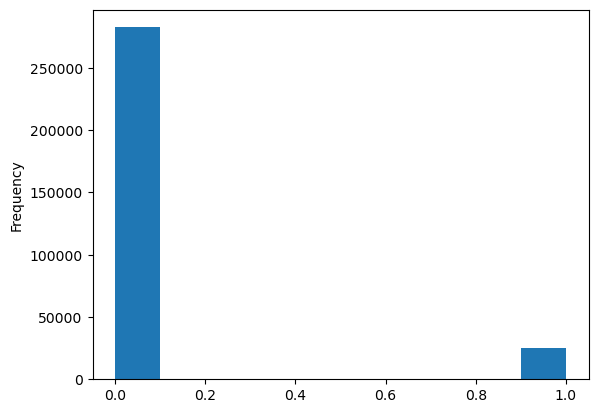

In [6]:
app_train['TARGET'].plot.hist();

Ces informations montrent qu'il s'agit d'un problème de classe déséquilibrée :  http://www.chioka.in/class-imbalance-problem/. 

Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes : http://xgboost.readthedocs.io/en/latest/parameter.html en fonction de leur représentation dans les données afin de refléter ce déséquilibre :

- scale_pos_weight : C'est l'un des hyperparamètres les plus importants pour les ensembles de données déséquilibrés dans les problèmes de classification binaire. Ce paramètre donne plus de poids à la classe minoritaire pendant l'entraînement, aidant le modèle à accorder une attention appropriée à cette classe.
- max_delta_step : Cet hyperparamètre aide à rendre la mise à jour du gradient plus conservatrice, souvent utile dans les ensembles de données très déséquilibrés. Il est généralement utilisé en conjonction avec scale_pos_weight pour améliorer la performance du modèle.

Paramètres relatifs à l'échantillonnage :

- subsample : Le pourcentage d'échantillons utilisés pour chaque arbre. Réduire cette valeur peut aider à éviter le surajustement.
- colsample_bytree, colsample_bylevel, colsample_bynode : Ces paramètres contrôlent le sous-échantillonnage des caractéristiques à différents niveaux de la construction des arbres. Ils peuvent être utiles pour gérer les surajustements.

En général, ajuster scale_pos_weight est un bon point de départ pour traiter des ensembles de données déséquilibrés. Il est également recommandé de faire une validation croisée pour déterminer les valeurs optimales de ces hyperparamètres pour votre ensemble de données spécifique.

### 1.3.2 - Missing Values

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons imputer ces valeurs manquantes. Dans un travail ultérieur, nous utiliserons des modèles tels que XGBoost qui peuvent traiter les valeurs manquantes sans nécessiter d'imputation : https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase.
Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. 
Par conséquent, nous conserverons toutes les colonnes pour l'instant.

### 1.3.3 - Column Types

In [9]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [10]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

### 1.3.4 - Anomalies

Les anomalies dans les données sont un problème que nous devons toujours surveiller lorsque nous faisons de l'AED. Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs dans les mesures ou à des mesures valables mais extrêmes. L'une des façons de détecter les anomalies de manière quantitative est d'examiner les statistiques d'une colonne à l'aide de la méthode `describe`. 

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

Les chiffres de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [13]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il des jours d'emploi ? 

In [14]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

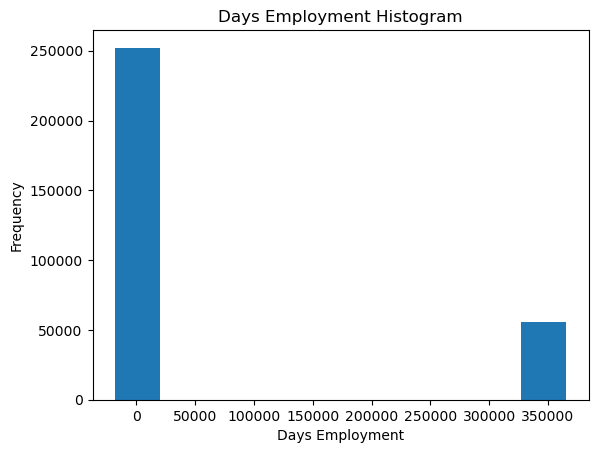

In [15]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'avère que les anomalies ont un taux de défaillance plus faible. 

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec un nombre (`np.nan`) et ensuite créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.



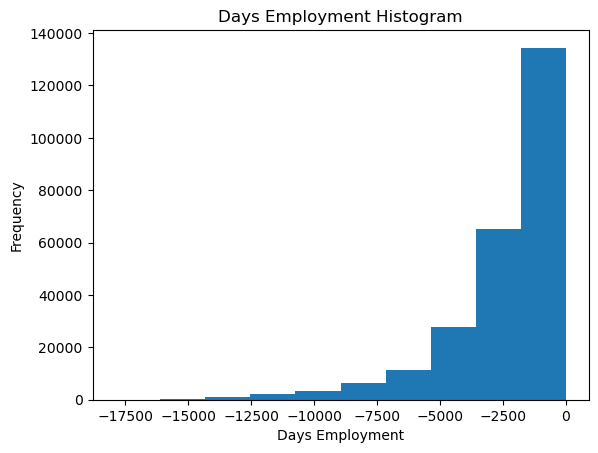

In [17]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de données semblent être à peu près ce que nous attendons, sans valeurs aberrantes évidentes. 

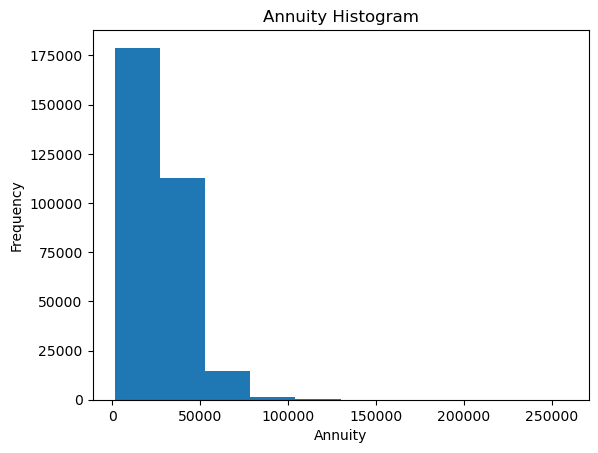

In [18]:
app_train['AMT_ANNUITY'].plot.hist(title = 'Annuity Histogram');
plt.xlabel('Annuity');

### 1.3.5 - Correlations

Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode .corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles entre les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [19]:
numeric_columns=app_train.select_dtypes(include=np.number).columns.tolist()
numeric_columns

# Matrice de corrélation
correlations = app_train[numeric_columns].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227


La corrélation `DAYS_BIRTH` est la plus positive. En regardant la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt en jours négatifs (pour une raison quelconque !). La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

#### 1.3.5.1 - Effect of Age on Repayment

In [20]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps. 

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

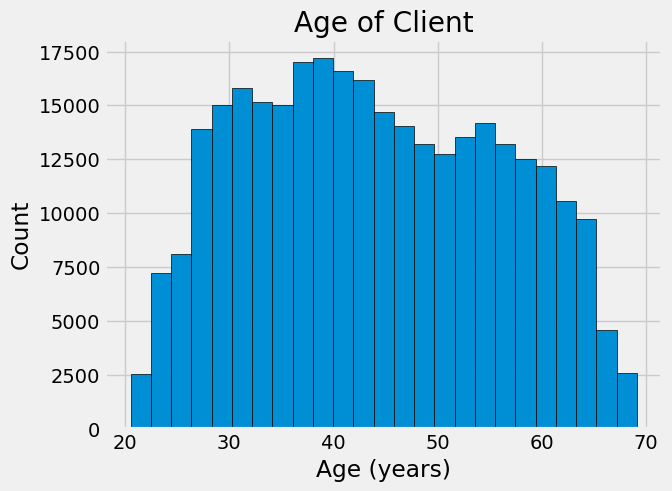

In [21]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables.
Pour visualiser l'effet de l'âge sur la cible, nous ferons ensuite un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. Un graphique d'estimation de la densité du noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le `kdeplot` de seaborn pour ce graphique.

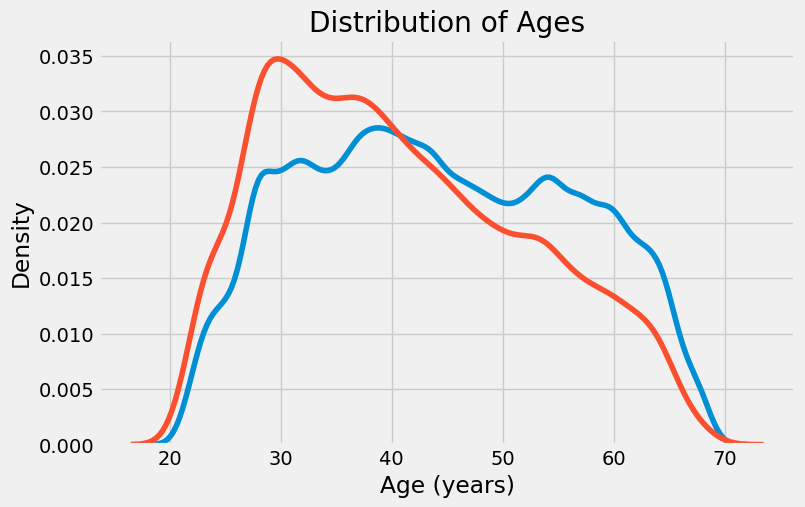

In [22]:
plt.figure(figsize = (8, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la Target == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge. 

Pour créer ce graphique, nous commençons par « découper » la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [23]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [24]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


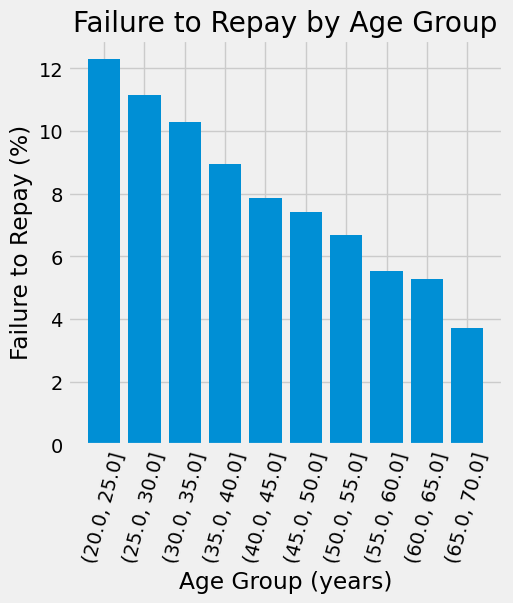

In [25]:
plt.figure(figsize = (5, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

#### 1.3.5.2 - Exterior Sources

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un « score normalisé de la source de données externe ». Je ne suis pas sûr de ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative réalisée à partir de nombreuses sources de données. 

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [26]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


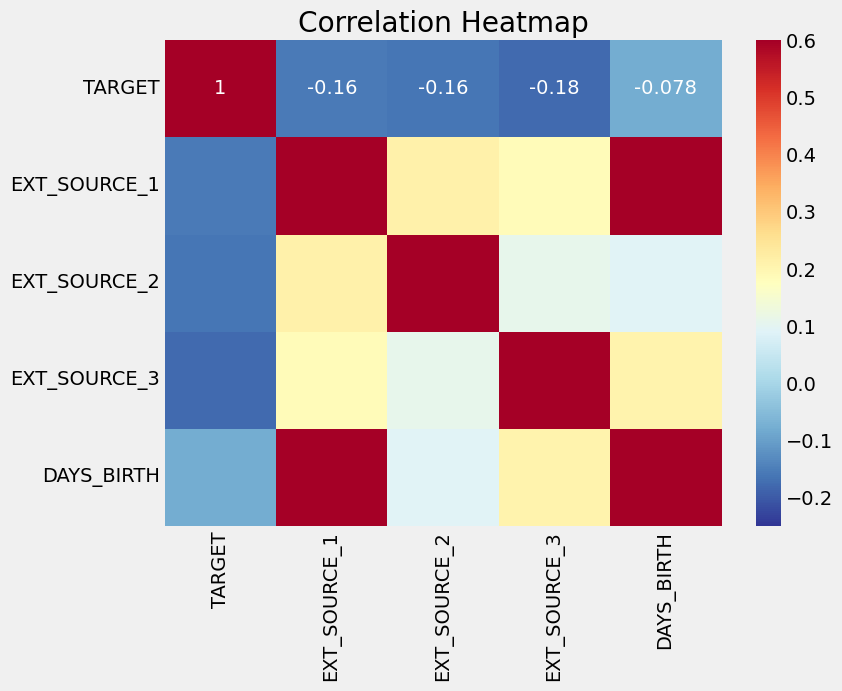

In [27]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

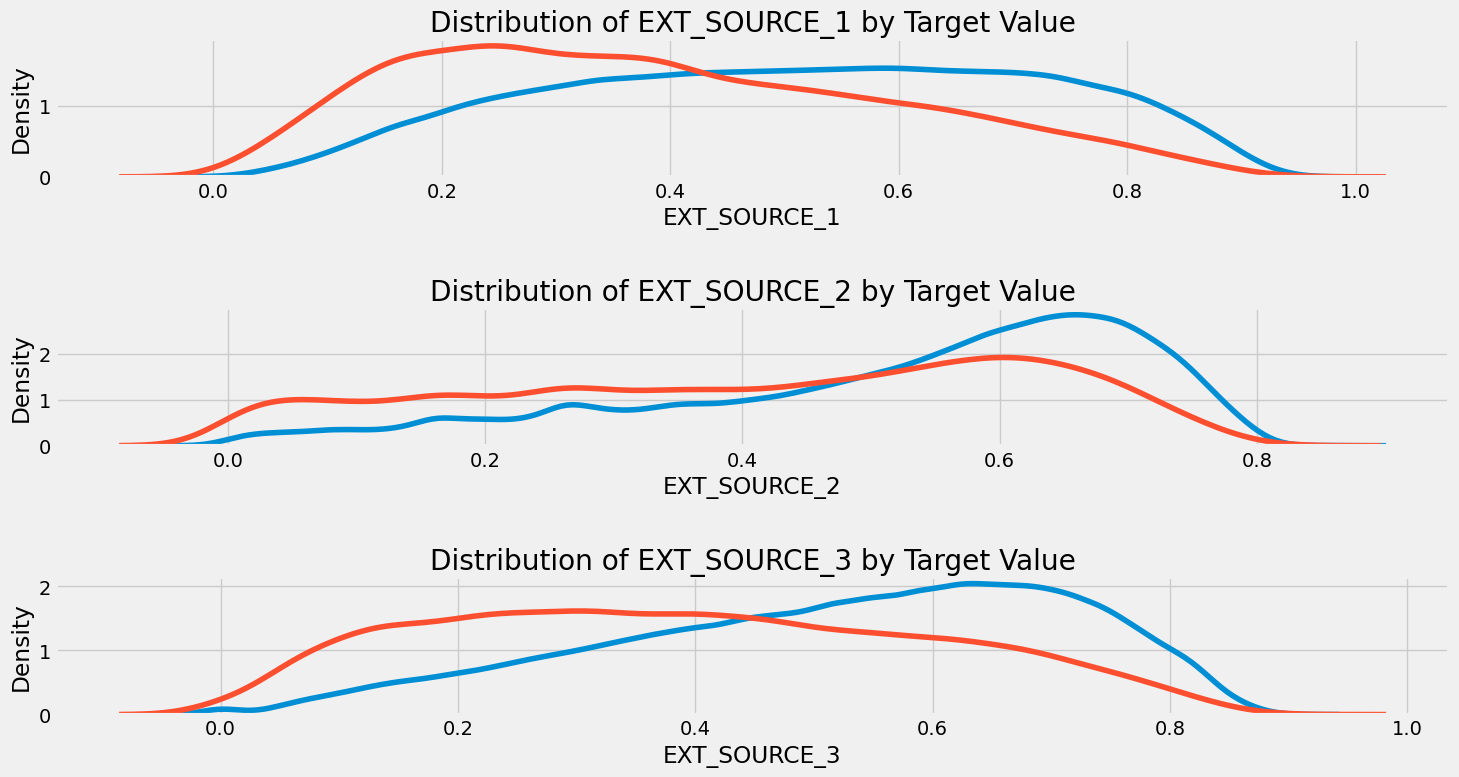

In [28]:
plt.figure(figsize = (15, 8))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles, mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt dans les délais.

### 1.3.6 - Pairs Plot

En guise de dernier graphique exploratoire, nous pouvons faire un pairplot des variables `EXT_SOURCE` et de la variable `DAYS_BIRTH`. Le Pairplot (https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions de variables uniques. 

In [29]:
# # Copy the data for plotting
# plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# # Add in the age of the client in years
# plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# # Drop na values and limit to first 100000 rows
# plot_data = plot_data.dropna().loc[:100000, :]

# # Function to calculate correlation coefficient between two columns
# def corr_func(x, y, **kwargs):
#     r = np.corrcoef(x, y)[0][1]
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.2, .8), xycoords=ax.transAxes,
#                 size = 20)

# # Create the pairgrid object
# grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
#                     hue = 'TARGET', 
#                     vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# # Upper is a scatter plot
# grid.map_upper(plt.scatter, alpha = 0.2)

# # Diagonal is a histogram
# grid.map_diag(sns.kdeplot)

# # Bottom is density plot
# grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

# plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

Dans ce graphique, le rouge indique les prêts non remboursés et le bleu les prêts remboursés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou YEARS_BIRTH), ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

## 1.4 - Feature Engineering

Le Feature Engineering a un meilleur retour sur investissement que la construction de modèles et l'ajustement des hyperparamètres. 

Feature Engineering se réfère à un processus général et peut impliquer à la fois la construction de caractéristiques : l'ajout de nouvelles caractéristiques à partir des données existantes, et la sélection de caractéristiques : le choix des caractéristiques les plus importantes ou d'autres méthodes de réduction de la dimensionnalité. Il existe de nombreuses techniques permettant de créer et de sélectionner des caractéristiques.


Nous pouvons créer quelques caractéristiques qui tentent de capturer ce que nous pensons être important pour savoir si un client va manquer à ses obligations de remboursement d'un prêt. Ici, je vais utiliser cinq caractéristiques qui ont été inspirées par ce script (https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) d'Aguiar :

* `CREDIT_INCOME_PERCENT` : le pourcentage du montant du crédit par rapport au revenu du client.
* `ANNUITY_INCOME_PERCENT` : le pourcentage de l'annuité du prêt par rapport au revenu du client
* `CREDIT_TERM` : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû).
* `DAYS_EMPLOYED_PERCENT` : le pourcentage des jours de travail par rapport à l'âge du client.


In [30]:
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

Nous devrions explorer ces variables de __connaissance du domaine__ visuellement dans un graphique. Pour toutes ces variables, nous ferons le même graphique KDE coloré par la valeur de la `TARGET`.

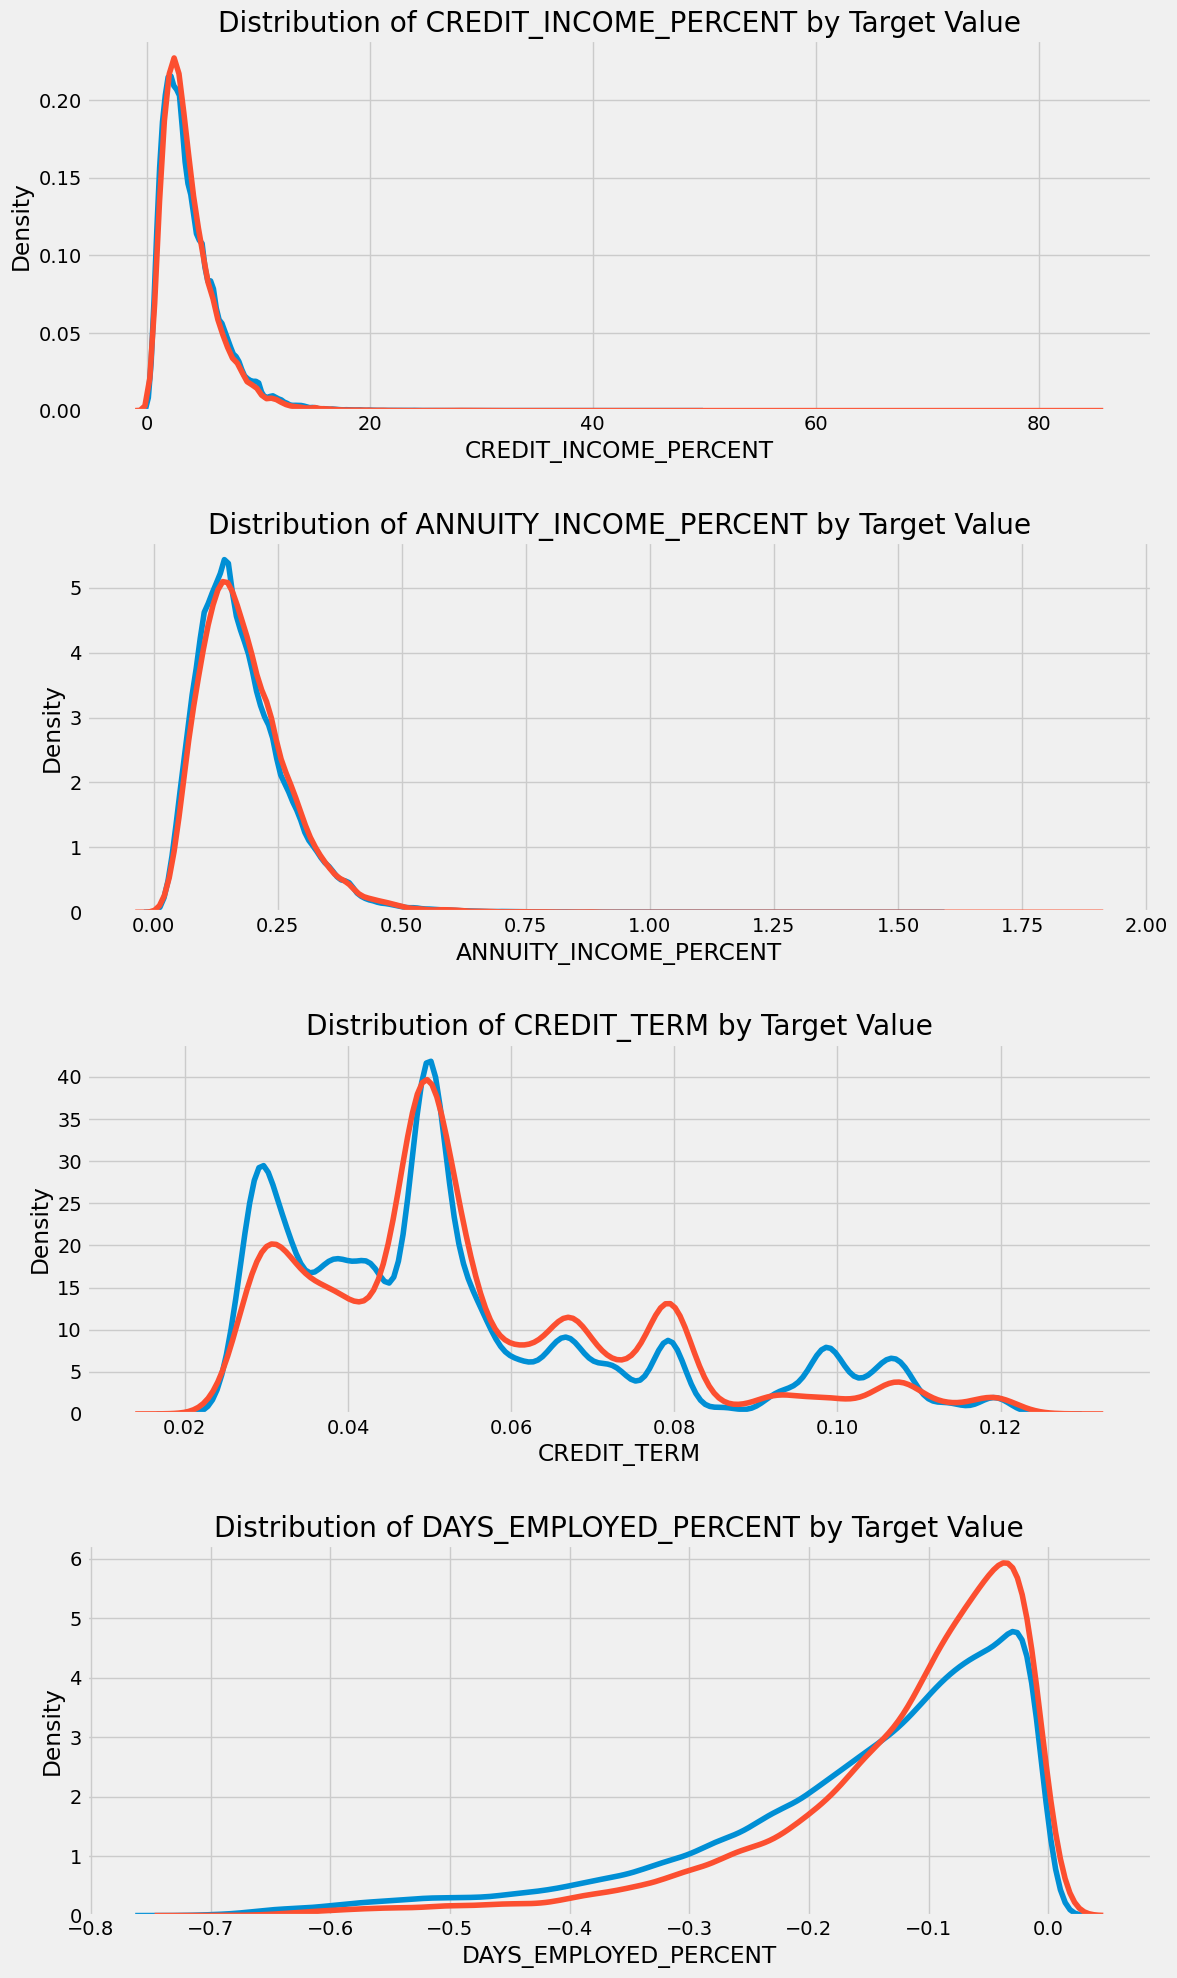

In [31]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Il est difficile de dire à l'avance si ces nouvelles fonctionnalités seront utiles. Le seul moyen d'en être sûr est de les essayer ! 

# 2 - Modélisation

In [32]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

### 2.1 - Split train en train/test

In [33]:
X = app_train_domain.drop('TARGET', axis=1)  
y = app_train_domain['TARGET']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2.2 - Encoding Variables catégorielles

Un modèle d'apprentissage automatique ne peut pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM : http://lightgbm.readthedocs.io/en/latest/Features.html. 

Nous devons donc trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il y a deux façons principales d'effectuer ce processus :
- Label encoding: attribue un nombre entier à chaque catégorie unique d'une variable catégorielle.
- One-hot encoding: créé une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne de la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le problème du Label encoding est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le scientifique des données un 1, mais si nous refaisions le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des nombres entiers est arbitraire. Par conséquent, lorsque nous procédons à l'encodage des étiquettes, le modèle peut utiliser la valeur relative de la caractéristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), le Label Encoding convient, mais pour plus de deux catégories uniques, le One Hot Encoding est l'option la plus sûre.


Le seul inconvénient du One Hot Encoding est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories. Pour y remédier, nous pouvons effectuer un OHE suivi d'une ACP ou d'autres méthodes de réduction de la dimensionnalité afin de réduire le nombre de dimensions tout en essayant de préserver l'information. 


Dans ce NB, nous utiliserons le Label Encoding pour toutes les variables catégorielles comportant seulement deux catégories et le OHE pour toutes les variables catégorielles comportant plus de deux catégories. Il se peut que ce processus doive être modifié au fur et à mesure que nous avançons dans le projet, mais pour l'instant, nous allons voir où cela nous mène. Nous n'utiliserons pas non plus de réduction de la dimensionnalité dans ce carnet, mais nous l'explorerons dans des itérations futures.

In [34]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train_domain:
    if app_train_domain[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_domain[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_domain[col])
            # Transform  training, val and testing data
            X_train[col] = le.transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
                        
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [35]:
# one-hot encoding of categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

print('Training Features shape: ', X_train.shape)
print('Test Features shape: ', X_test.shape)


Training Features shape:  (246008, 247)
Test Features shape:  (61503, 247)


Il doit y avoir les mêmes colonnes dans le train et dans le test. Si le OHE a créé plus de colonnes dans le train que dans le test (parce qu'il y avait des variables catégorielles dont les catégories n'étaient pas représentées dans les données de test), alors il faut supprimer les colonnes des données d'apprentissage qui ne se trouvent pas dans les données de test. Pour ça, nous devons « aligner » les cadres de données. 

In [36]:
# # Align the training and testing data, keep only columns present in both dataframes
# X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)

# print('Training Features shape: ', X_train.shape)
# print('Val Features shape: ', X_test.shape)


Rmq : Lorsqu'on utilise la méthode align() avec l'option join='inner' pour aligner deux DataFrames pandas sur l'axe des colonnes, toutes les colonnes qui ne sont pas communes aux deux DataFrames sont supprimées du résultat final. Cela signifie que toute information contenue dans ces colonnes supprimées est perdue dans les DataFrames retournés par la méthode.

## 2.3 - Imputation MV et normalisation avec un min max scaler

In [37]:
from sklearn.preprocessing import MinMaxScaler

   
# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)


Training data shape:  (246008, 247)
Testing data shape:  (61503, 247)


## 2.4 - Baseline = Dummy Classifier

Pour obtenir une baseline :
- nous utiliserons toutes les caractéristiques après avoir encodé les variables catégorielles.
- Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation)
- et normaliser les caractéristiques.


### 2.4.1 - Entrainement et prédictions

Pour avoir une référence et, comme le jeu de données est déséquilibré, on va tester un modèle naïf avec la stratégie 'stratified', qui va générer des prédictions en respectant la distribution des classes de l'ensemble d'entrainement

In [38]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Entraînement du Dummy Classifier
start_time=time.time()

dummy_clf.fit(X_train, y_train)

end_time = time.time()
training_execution_time = round(end_time - start_time, 2)
print(f"Le temps d'entrainement est de {training_execution_time} secondes.")

Le temps d'entrainement est de 0.01 secondes.


Maintenant que le modèle a été entraîné, nous pouvons l'utiliser pour faire des prédictions. Nous voulons prédire les probabilités de ne pas rembourser un prêt, nous utilisons donc la méthode `predict.proba` du modèle. Celle-ci renvoie un tableau m x 2 où m est le nombre d'observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, la somme des deux colonnes doit être égale à 1). Nous voulons connaître la probabilité que le prêt ne soit pas remboursé, nous sélectionnerons donc la deuxième colonne.

Le code suivant effectue les prédictions et sélectionne la colonne correcte.

In [39]:
# Prédictions 
start_time=time.time()

y_pred_dummy_train = dummy_clf.predict(X_train)
y_pred_dummy_test = dummy_clf.predict(X_test)

dummy_pred_train = dummy_clf.predict_proba(X_train)[:, 1]
dummy_pred_test = dummy_clf.predict_proba(X_test)[:, 1]

end_time = time.time()
predicting_execution_time = round(end_time - start_time, 2)
print(f"Le temps de prédiction est de {predicting_execution_time} secondes.")

Le temps de prédiction est de 0.03 secondes.


### 2.4.2 - Elaboration du score métier

#### 2.4.2.1 - Définition de la matrice de coûts

- Faux Négatif (FN) : un mauvais client est prédit comme bon. Fixons ce coût à 10.
- Faux Positif (FP) : un bon client est prédit comme mauvais. Fixons ce coût à 1.

#### 2.4.2.2 - Calcul du coût total des erreurs

Pour chaque seuil de probabilité p utilisé pour classifier les observations en positives (clients défaillants) ou négatives (bons clients), on calcule le coût total des erreurs comme suit :
- on va calculer le nombre de FN et FP pour le seuil p
- on va calculer le coût total : coût total (p) = coût FN x Nbre FN + Coût FP x Nbre FP

In [40]:
def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

#### 2.4.2.3 - Optimisation du seuil

Il va s'agir d'utiliser une méthode pour trouver le seuil p qui minimise le Cout total
Cette étape peut impliquer :
- Analyse de la courbe des coûts : Tracage du coût total en fonction de différents seuils pour identifier visuellement le minimum.
- Recherche algorithmique :  Utilisation de techniques comme la recherche exhaustive dans un intervalle de seuils ou des méthodes plus sophistiquées comme l'optimisation numérique.

In [41]:
thresholds = np.linspace(0, 1, 100) # génére 100 valeurs de seuil uniformément réparties entre 0 et 1

costs = [calculate_cost_threshold(y_test, dummy_pred_test, thr, cost_fn=10, cost_fp=1) for thr in thresholds]


In [42]:
optimal_threshold = round(thresholds[np.argmin(costs)],2) # détermine le seuil optimal en trouvant l'indice du coût minimal 
                                                        # dans la liste costs à l'aide de np.argmin(), 
                                                        # puis en récupérant la valeur correspondante dans thresholds. La valeur est arrondie à 2 décimales pour plus de lisibilité.
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.01


### 2.4.3 - Analyse des résultats du test

#### 2.4.3.1 - Confusion matrix et Classification Reports au seuil optimal

In [43]:
y_pred_optimal = (dummy_pred_test >= optimal_threshold).astype(int)

Rmq : (dummy_pred_test >= optimal_threshold) effectue une comparaison élément par élément entre les probabilités prédites et le seuil optimal. Cela crée un tableau de booléens où chaque élément est True si la probabilité prédite est supérieure ou égale au seuil optimal, sinon False.
.astype(int) est utilisé pour convertir les valeurs booléennes (True/False) en entiers (1/0). Ainsi, les valeurs supérieures ou égales au seuil optimal seront converties en 1 et les autres en 0.
Le résultat final, y_pred_optimal, est un tableau de prédictions binaires où chaque élément est 1 si la probabilité prédite correspondante est supérieure ou égale au seuil optimal, sinon 0.

In [44]:
pd.crosstab(y_test, y_pred_optimal, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,52008,4546
1,4576,373


In [45]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 2.4.3.2 - f1 score de la classe 1 au seuil optimal

In [46]:
report = classification_report(y_test, y_pred_optimal, output_dict=True) # output_dict=True indique à la fonction classification_report 
                                                    # de renvoyer le rapport sous forme de dictionnaire Python plutôt que sous forme de chaîne de caractères.

In [47]:
f1_score_1_test = round(report['1']['f1-score'],2)
print(f"F1 Score for class '1': {f1_score_1_test}")

F1 Score for class '1': 0.08


#### 2.4.3.2 - Accuracy du test au seuil optimal

In [48]:
accuracy_test = round(accuracy_score(y_test, y_pred_optimal),2)
print("Accuracy du test:", accuracy_test)

Accuracy du test: 0.85


#### 2.4.3.3 - AUC du train et du test

In [52]:
# Calculer l'AUC sur le train
auc_train = round(roc_auc_score(y_train, dummy_pred_train),2)
print("Train AUC:", auc_train)

Train AUC: 0.5


In [53]:
# Calculer l'AUC sur le test
auc_test = round(roc_auc_score(y_test, dummy_pred_test),2)
print("Test AUC:", auc_test)

Test AUC: 0.5


Avec ce modèle, on a 50% de chance que, en prenant 2 individus aléatoirement, l'individu le mieux scoré ait une target = 1.

### 2.4.4 - Enregistrement du modèle dans MLFlow

In [54]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai déclarés au dessus
    # mlflow.log_params(params)

    # Log la métrique de perte que j'ai déclarée au dessus
    
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    
    mlflow.log_metric("f1_score_1_test", f1_score_1_test)
    mlflow.log_metric("accuracy du test", accuracy_test)
    
    mlflow.log_metric("auc_train", auc_train)
    mlflow.log_metric("auc_test", auc_test)
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", predicting_execution_time)

    
    

    # Définir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "Dummy model _ Methode Stratified ")

    # Infer the model signature
    signature = infer_signature(X_train, dummy_clf.predict(X_train)) # infer_signature génère automatiquement une "signature" 
                                                              # qui décrit les entrées et les sorties du modèle. 
                                                              # Cela inclut les types de données et les formats attendus par le modèle, 
                                                              # facilitant ainsi l'intégration et la réutilisation du modèle 
                                                              # dans différents environnements.

    
    # Log le model
    model_info = mlflow.sklearn.log_model(
        sk_model=dummy_clf, # le modèle
        artifact_path="dummy_model", # le chemin où le modèle sera enregistré
        signature=signature, # la signature du modèle
        input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
        registered_model_name="scoring-credit-dummy", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
    )


2024/05/25 16:31:05 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Credit Scoring - Projet_7' does not exist. Creating a new experiment.
Registered model 'scoring-credit-dummy' already exists. Creating a new version of this model...
2024/05/25 16:32:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-dummy, version 4
Created version '4' of model 'scoring-credit-dummy'.


## 2.2 - Régression logistique 

### 2.2.1 - Définition des fonctions de scoring

In [55]:
# Fonction pour calculer l'AUC
def auc_score(y_true, y_pred_proba):
    return roc_auc_score(y_true, y_pred_proba)

In [56]:
# Fonction pour calculer le F1 score de la classe positive
def f1_positive(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

In [57]:
# Fonction pour calculer le F1 score avec un seuil optimal basé sur la matrice de coûts
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_f1


In [58]:
# Scorers personnalisés
scorers = {
    'AUC': make_scorer(auc_score, needs_proba=True),
    'F1_Positive': make_scorer(f1_positive),
    'Custom_F1': make_scorer(custom_f1, needs_proba=True)
}

### 2.2.2 - GridSearchCV

In [59]:
# Configuration du modèle
model = LogisticRegression( solver='saga', 
                            max_iter=10000, 
                            random_state=42,
                            class_weight = 'balanced'
)

# Paramètres à passer au Randomized Search
param_grid = {
      'C': np.logspace(-4, 4, 10),  # Valeurs de C sur une échelle logarithmique
       'penalty': ['l1', 'l2'],  # L1 pour Lasso, L2 pour Ridge
      
}

# GridSearchCV
grid_search  = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring=scorers,
    refit='AUC', # quel score doit être utilisé pour ajuster le modèle final sur l'ensemble des données une fois que la recherche des meilleurs hyperparamètres est terminée.
    cv=5,  
    verbose=3
)

Notes :  

1. **solver='saga'**
Le paramètre solver spécifie l'algorithme à utiliser pour l'optimisation des poids du modèle dans le processus d'apprentissage. saga est une variante de l'algorithme de descente de gradient stochastique qui est bien adaptée pour les grands jeux de données, car elle est efficace en termes de mémoire et supporte les deux types de régularisation L1 ((pour la sélection de caractéristiques) et L2 (pour éviter le surajustement)

2. **max_iter=10000**
Le paramètre max_iter définit le nombre maximal d'itérations que l'algorithme de résolution peut exécuter pour atteindre la convergence. Une valeur élevée comme 10000 assure que l'algorithme a suffisamment de temps pour converger, particulièrement utile dans des scénarios où le modèle a du mal à converger ou lorsque le jeu de données est complexe ou très grand.
Augmenter max_iter permet à l'algorithme plus d'itérations pour trouver les poids optimaux, réduisant ainsi le risque d'arrêter l'apprentissage trop tôt avant que le modèle n'atteigne la stabilité. Bien que permettre plus d'itérations puisse améliorer la précision du modèle, cela peut également augmenter le temps de calcul. Il est donc important de trouver un équilibre entre le nombre d'itérations et les ressources de calcul disponibles.

In [60]:
# Fractionner les données pour obtenir un échantillon de 0.1% sinon trop long
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.001, random_state=42)


In [61]:
### Entrainement sur l'échantillon
start_time=time.time()

grid_search.fit(X_train_sample, y_train_sample)

end_time = time.time()
execution_time = round(end_time - start_time, 2)
print(f"Le temps d'execution est de {execution_time} secondes.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.0001, penalty=l1; AUC: (test=0.500) Custom_F1: (test=0.148) F1_Positive: (test=0.000) total time=   0.1s
[CV 2/5] END C=0.0001, penalty=l1; AUC: (test=0.500) Custom_F1: (test=0.151) F1_Positive: (test=0.000) total time=   0.1s
[CV 3/5] END C=0.0001, penalty=l1; AUC: (test=0.500) Custom_F1: (test=0.151) F1_Positive: (test=0.151) total time=   0.1s
[CV 4/5] END C=0.0001, penalty=l1; AUC: (test=0.500) Custom_F1: (test=0.151) F1_Positive: (test=0.151) total time=   0.1s
[CV 5/5] END C=0.0001, penalty=l1; AUC: (test=0.500) Custom_F1: (test=0.151) F1_Positive: (test=0.151) total time=   0.1s
[CV 1/5] END C=0.0001, penalty=l2; AUC: (test=0.522) Custom_F1: (test=0.148) F1_Positive: (test=0.000) total time=   0.0s
[CV 2/5] END C=0.0001, penalty=l2; AUC: (test=0.417) Custom_F1: (test=0.151) F1_Positive: (test=0.100) total time=   0.1s
[CV 3/5] END C=0.0001, penalty=l2; AUC: (test=0.311) Custom_F1: (test=0.151) F1_Posi

In [62]:
# Meilleurs paramètres et meilleure AUC
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure AUC sur CV:", grid_search.best_score_)

Meilleurs paramètres: {'C': 0.3593813663804626, 'penalty': 'l2'}
Meilleure AUC sur CV: 0.5305797101449277


In [63]:
# Extraire les meilleurs paramètres
best_params = grid_search.best_params_

### 2.2.3 - Analyse de la cross_validation

In [64]:
# Access the cross-validation results
cv_results = grid_search.cv_results_

In [65]:
# Conversion de cv_results_ en DataFrame
df_cv_results = pd.DataFrame(cv_results)
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_F1_Positive,split1_test_F1_Positive,split2_test_F1_Positive,split3_test_F1_Positive,split4_test_F1_Positive,mean_test_F1_Positive,std_test_F1_Positive,rank_test_F1_Positive,split0_test_Custom_F1,split1_test_Custom_F1,split2_test_Custom_F1,split3_test_Custom_F1,split4_test_Custom_F1,mean_test_Custom_F1,std_test_Custom_F1,rank_test_Custom_F1
0,0.005364,0.005573,0.190514,0.026392,0.0001,l1,"{'C': 0.0001, 'penalty': 'l1'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,11,0.0,0.0,0.150943,0.150943,0.150943,0.090566,0.073947,6,0.148148,0.150943,0.150943,0.150943,0.150943,0.150384,0.001118,16
1,0.015723,0.000998,0.207864,0.042621,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",0.521739,0.416667,0.311111,0.622222,0.655556,0.505459,0.128127,3,0.0,0.1,0.000000,0.200000,0.210526,0.102105,0.091863,4,0.148148,0.150943,0.150943,0.150943,0.150943,0.150384,0.001118,16
2,0.001646,0.001407,0.196897,0.024235,0.000774,l1,"{'C': 0.000774263682681127, 'penalty': 'l1'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,11,0.0,0.0,0.150943,0.150943,0.150943,0.090566,0.073947,6,0.148148,0.150943,0.150943,0.150943,0.150943,0.150384,0.001118,16
3,0.013993,0.003462,0.212920,0.045264,0.000774,l2,"{'C': 0.000774263682681127, 'penalty': 'l2'}",0.527174,0.416667,0.311111,0.622222,0.661111,0.507657,0.129587,2,0.0,0.1,0.000000,0.206897,0.210526,0.103485,0.093362,2,0.210526,0.150943,0.150943,0.186047,0.157895,0.171271,0.023514,15
4,0.001327,0.001174,0.208634,0.028857,0.005995,l1,"{'C': 0.005994842503189409, 'penalty': 'l1'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,11,0.0,0.0,0.000000,0.150943,0.000000,0.030189,0.060377,20,0.148148,0.150943,0.150943,0.150943,0.150943,0.150384,0.001118,16


In [66]:
df_cv_results=df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_F1_Positive,split1_test_F1_Positive,split2_test_F1_Positive,split3_test_F1_Positive,split4_test_F1_Positive,mean_test_F1_Positive,std_test_F1_Positive,rank_test_F1_Positive,split0_test_Custom_F1,split1_test_Custom_F1,split2_test_Custom_F1,split3_test_Custom_F1,split4_test_Custom_F1,mean_test_Custom_F1,std_test_Custom_F1,rank_test_Custom_F1
9,4.804310,0.772417,0.201471,0.029822,0.359381,l2,"{'C': 0.3593813663804626, 'penalty': 'l2'}",0.619565,0.422222,0.366667,0.661111,0.583333,0.530580,0.115194,1,0.0,0.181818,0.125,0.150000,0.000000,0.091364,0.076741,5,0.240000,0.222222,0.166667,0.315789,0.266667,0.242269,0.049241,1
3,0.013993,0.003462,0.212920,0.045264,0.000774,l2,"{'C': 0.000774263682681127, 'penalty': 'l2'}",0.527174,0.416667,0.311111,0.622222,0.661111,0.507657,0.129587,2,0.0,0.100000,0.000,0.206897,0.210526,0.103485,0.093362,2,0.210526,0.150943,0.150943,0.186047,0.157895,0.171271,0.023514,15
1,0.015723,0.000998,0.207864,0.042621,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",0.521739,0.416667,0.311111,0.622222,0.655556,0.505459,0.128127,3,0.0,0.100000,0.000,0.200000,0.210526,0.102105,0.091863,4,0.148148,0.150943,0.150943,0.150943,0.150943,0.150384,0.001118,16
11,1.137712,2.056784,0.219070,0.012494,2.782559,l2,"{'C': 2.782559402207126, 'penalty': 'l2'}",0.516304,0.527778,0.350000,0.616667,0.511111,0.504372,0.086228,4,0.0,0.000000,0.000,0.166667,0.222222,0.077778,0.096864,12,0.222222,0.250000,0.150943,0.240000,0.266667,0.225966,0.040183,3
19,1.071114,0.151275,0.182663,0.062839,10000.0,l2,"{'C': 10000.0, 'penalty': 'l2'}",0.451087,0.572222,0.400000,0.611111,0.483333,0.503551,0.077677,5,0.0,0.000000,0.000,0.166667,0.000000,0.033333,0.066667,16,0.148148,0.150943,0.150943,0.222222,0.285714,0.191594,0.054753,9


In [67]:
# Les résultats de la combinaison la mieux classée
df_cv_results.iloc[0]

mean_fit_time                                                 4.80431
std_fit_time                                                 0.772417
mean_score_time                                              0.201471
std_score_time                                               0.029822
param_C                                                      0.359381
param_penalty                                                      l2
params                     {'C': 0.3593813663804626, 'penalty': 'l2'}
split0_test_AUC                                              0.619565
split1_test_AUC                                              0.422222
split2_test_AUC                                              0.366667
split3_test_AUC                                              0.661111
split4_test_AUC                                              0.583333
mean_test_AUC                                                 0.53058
std_test_AUC                                                 0.115194
rank_test_AUC       

On obtient une ligne par combinaison de variables :
- **'mean_fit_time'** et **'std_fit_time'** : Temps moyen et écart-type du temps d'ajustement, respectivement, à travers toutes les folds et les combinaisons de paramètres.  
- **'mean_score_time'** et **'std_score_time'** : Temps moyen et écart-type du temps d'évaluation, respectivement, à travers toutes les folds et les combinaisons de paramètres.
  
- **'param_C'** et **'param_penalty'** etc.. : Les valeurs des hyperparamètres pour chaque combinaison.  
- **'params'** : Liste de dictionnaires représentant les combinaisons de paramètres.
  
- **'split0_test_AUC'**, **'split1_test_AUC'**, ...,  : AUC du test pour chaque fold.  
- **'mean_test_AUC'** et **'std_test_AUC'** : Moyenne et écart-type des AUC à travers toutes les folds pour chaque combinaison de paramètres.  
- **'rank_test_AUC'** : Le classement de chaque combinaison de paramètres basé sur la moyenne des AUC.  


Etc...


=> Dans notre exemple, c'est la combinaison :
{'C': 0.3593813663804626, 'penalty': 'l2'}	
 qui a obtenu la meilleure AUC, comme indiqué par le rang 1 dans les deux cas.

In [68]:
df_test_results_auc = df_cv_results[['split0_test_AUC',
                'split1_test_AUC',
                'split2_test_AUC',
                'split3_test_AUC',
                'split4_test_AUC']][df_cv_results['rank_test_AUC']==1].values

df_test_results_auc

array([[0.61956522, 0.42222222, 0.36666667, 0.66111111, 0.58333333]])

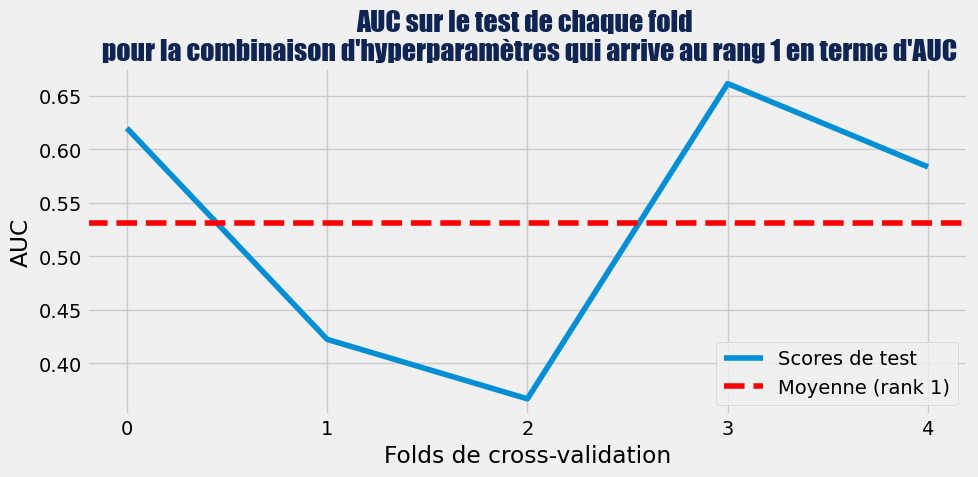

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))

# Tracer les scores de test
ax.plot(range(0, 5), df_test_results_auc.reshape(-1), label='Scores de test')

# Tracer la moyenne pour les combinaisons avec rank_test_adjusted_r2 == 1
mean_scores_rank_1 = df_cv_results.loc[df_cv_results['rank_test_AUC'] == 1, 'mean_test_AUC']
ax.axhline(y=mean_scores_rank_1.values[0], color='r', linestyle='--', label='Moyenne (rank 1)')

# Définir les propriétés de l'axe
ax.set_xticks(range(0, 5))
ax.set_xlabel("Folds de cross-validation")
ax.set_ylabel('AUC')
ax.set_title("AUC sur le test de chaque fold \n pour la combinaison d'hyperparamètres qui arrive au rang 1 en terme d'AUC", fontsize=20,weight="bold", fontname="Impact", color="#0e2452")

# Ajouter une légende
ax.legend()

fig.tight_layout()

plt.show()

Une grande variance entre les folds. Ce n'est pas stable. Dû à la taille de l'échantillon ?

### 2.2.4 - Entrainement du modèle final sur les données d'entrainement

In [70]:
final_model = LogisticRegression(
    solver='saga',
    max_iter=10000,
    random_state=42,
    class_weight='balanced',
    C=best_params['C'],
    penalty=best_params['penalty']
)

In [71]:
# Entraînement du modèle sur l'ensemble des données d'entraînement
start_time=time.time()

final_model.fit(X_train, y_train)

end_time = time.time()
training_execution_time = round(end_time - start_time, 2)
print(f"Le temps d'entrainement est de {training_execution_time} secondes.")


Le temps d'entrainement est de 101.03 secondes.


### 2.2.5 - Prédictions sur le train et sur le test

In [72]:
start_time=time.time()

# sur le train
y_train_pred_proba = final_model.predict_proba(X_train)[:, 1]
y_train_pred = final_model.predict(X_train)

# sur le test
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = final_model.predict(X_test)

end_time = time.time()
predicting_execution_time = round(end_time - start_time, 2)
print(f"Le temps de prédiction est de {predicting_execution_time} secondes.")

Le temps de prédiction est de 0.27 secondes.


### 2.2.6 - Evaluation du modèle 

#### 2.2.6.1 - Seuil optimal

In [73]:
costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
optimal_threshold = round(thresholds[np.argmin(costs)],2) 
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.54


#### 2.2.6.2 - Confusion matrix et Classification Reports au seuil opt

In [74]:
y_pred_optimal = (y_test_pred_proba >= optimal_threshold).astype(int)

In [75]:
pd.crosstab(y_test, y_pred_optimal, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,42149,14405
1,1881,3068


In [76]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56554
           1       0.18      0.62      0.27      4949

    accuracy                           0.74     61503
   macro avg       0.57      0.68      0.56     61503
weighted avg       0.89      0.74      0.79     61503



#### 2.2.6.3 - f1 score de la classe 1 au seuil optimal

In [77]:
report = classification_report(y_test, y_pred_optimal, output_dict=True) # output_dict=True indique à la fonction classification_report 
                                                    # de renvoyer le rapport sous forme de dictionnaire Python plutôt que sous forme de chaîne de caractères.

In [78]:
f1_score_1_test = round(report['1']['f1-score'],2)
print(f"F1 Score for class '1': {f1_score_1_test}")

F1 Score for class '1': 0.27


#### 2.2.6.4 - Accuracy du test au seuil optimal

In [79]:
accuracy_test = round(accuracy_score(y_test, y_pred_optimal),2)
print("Accuracy du test:", accuracy_test)

Accuracy du test: 0.74


#### 2.2.6.5 - AUC du train et du test

In [80]:
# Calculer l'AUC sur le train
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print("Train AUC:", auc_train)

Train AUC: 0.7503371452685599


In [81]:
# Calculer l'AUC sur le test
auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("Test AUC:", auc_test)

Test AUC: 0.7491824824834059


### 2.2.7 - Enregistrement du modèle dans ML Flow

In [82]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai déclarés au dessus
    mlflow.log_params(best_params)

    # Log la métrique de perte que j'ai déclarée au dessus
    
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    
    mlflow.log_metric("f1_score_1_test", f1_score_1_test)
    mlflow.log_metric("accuracy du test", accuracy_test)
    
    mlflow.log_metric("auc_train", auc_train)
    mlflow.log_metric("auc_test", auc_test)
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", predicting_execution_time)

    
    

    # Définir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "Logistic Regression with GridSearchCV ")

    # Infer the model signature
    signature = infer_signature(X_train, final_model.predict(X_train)) # infer_signature génère automatiquement une "signature" 
                                                              # qui décrit les entrées et les sorties du modèle. 
                                                              # Cela inclut les types de données et les formats attendus par le modèle, 
                                                              # facilitant ainsi l'intégration et la réutilisation du modèle 
                                                              # dans différents environnements.

    
    # Log le model
    model_info = mlflow.sklearn.log_model(
        sk_model=final_model, # le modèle
        artifact_path="logistic_regression_model", # le chemin où le modèle sera enregistré
        signature=signature, # la signature du modèle
        input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
        registered_model_name="scoring-credit-logistic-regression", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
    )


Registered model 'scoring-credit-logistic-regression' already exists. Creating a new version of this model...
2024/05/25 16:38:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-logistic-regression, version 4
Created version '4' of model 'scoring-credit-logistic-regression'.


# 2.2 - Random Forest

Pour tenter d'améliorer les performances de notre baseline, nous pouvons essayer d'utiliser une Random Forest sur les mêmes données d'entraînement pour voir comment cela affecte les performances. Le Random Forest est un modèle beaucoup plus puissant, en particulier lorsque nous utilisons des centaines d'arbres. Nous utiliserons 100 arbres dans la forêt aléatoire.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, 
                                       random_state = 50, 
                                       verbose = 1, 
                                       n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

__Le score de ce modèle devrait être autour de 0.678.__

# Quel est ce score ? l'AUC du train ?

## 2.3 - Make Predictions using Engineered Features

La seule façon de voir si les caractéristiques polynomiales et la connaissance du domaine ont amélioré le modèle est de former et de tester un modèle sur ces caractéristiques ! Nous pouvons alors comparer les performances de la soumission à celles du modèle sans ces caractéristiques pour évaluer l'effet de notre ingénierie des caractéristiques.

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, 
                                            random_state = 50, 
                                            verbose = 1, 
                                            n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

Ce modèle a obtenu un score de 0,678, soit exactement le même que celui sans les caractéristiques techniques. Compte tenu de ces résultats, il ne semble pas que notre construction de caractéristiques ait été utile dans ce cas. 

## 2.4 - Testing Domain Features

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

Ce score est de 0,679 lorsqu'il est soumis, ce qui montre probablement que les caractéristiques élaborées ne sont d'aucune utilité dans ce modèle (elles le sont toutefois dans le modèle de renforcement du gradient à la fin du manuel).

Dans les cahiers suivants, nous ferons plus de feature engineering en utilisant les informations des autres sources de données. D'après notre expérience, cela aidera certainement notre modèle ! 

## 2.5 - Model Interpretation: Feature Importances

Comme méthode simple pour voir quelles variables sont les plus pertinentes, nous pouvons regarder les importances des caractéristiques de la forêt aléatoire. Compte tenu des corrélations observées dans l'analyse exploratoire des données, nous devrions nous attendre à ce que les caractéristiques les plus importantes soient `EXT_SOURCE` et `DAYS_BIRTH`. Nous pourrions utiliser ces importances de caractéristiques comme méthode de réduction de la dimensionnalité dans des travaux futurs.

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

Comme on pouvait s'y attendre, les caractéristiques les plus importantes sont celles qui traitent de `EXT_SOURCE` et de `DAYS_BIRTH`. L'importance des caractéristiques n'est pas la méthode la plus sophistiquée pour interpréter un modèle ou effectuer une réduction de la dimensionnalité, mais elle nous permet de commencer à comprendre les facteurs que notre modèle prend en compte lorsqu'il fait des prédictions. 

# je ne trouve pas la même chose !

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

Nous constatons que les quatre fonctionnalités que nous avons conçues à la main ont été classées parmi les 15 plus importantes ! Cela devrait nous conforter dans l'idée que notre connaissance du domaine était, au moins partiellement, sur la bonne voie.

## 2.6 - Light Gradient Boosting Machine

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ 
The LightGBM library : http://lightgbm.readthedocs.io/en/latest/Quick-Start.html

LightGBM est un framework d'apprentissage automatique développé par Microsoft, qui est largement utilisé pour les tâches de classification, de régression et de classement. Il appartient à la catégorie des algorithmes de boosting basés sur des arbres de décision, similaire à XGBoost et CatBoost. Voici quelques points clés pour comprendre LightGBM :

LightGBM utilise le gradient boosting, une technique qui construit de manière itérative des modèles de prévision en ajoutant des arbres de décision faibles, chaque nouvel arbre étant construit pour corriger les erreurs des arbres précédents. Ces arbres sont ajoutés séquentiellement jusqu'à ce qu'un nombre spécifié d'arbres soit atteint ou que les améliorations deviennent négligeables.

**Son fonctionnement** :
1. Initialisation 
- LightGBM commence par créer un modèle initial très simple, souvent appelé "base learner". Ce modèle peut être quelque chose d’aussi simple qu’une régression ou un arbre de décision très basique. L'idée est de créer un point de départ pour l'algorithme.
- Ce premier modèle fait une prédiction basique qui est généralement loin d'être parfaite mais fournit une base sur laquelle construire.
2. Apprendre des Erreurs
- Après avoir fait ses premières prédictions, LightGBM examine les erreurs — les différences entre les valeurs prédites et les valeurs réelles. Ces erreurs sont aussi appelées résidus.
- Un nouveau modèle est ensuite entraîné, mais au lieu de prédire la valeur cible originale, il essaie de prédire ces résidus (les erreurs du premier modèle). L’idée est de corriger là où le premier modèle s’est trompé.
3. Répéter
- Ce processus de correction des erreurs en entraînant un nouveau modèle sur les résidus est répété plusieurs fois. Chaque nouveau modèle est conçu pour améliorer les prédictions là où les modèles précédents ont échoué.
- À chaque étape, l’algorithme se concentre de plus en plus sur les cas les plus difficiles à prédire, raffinant progressivement sa capacité à modéliser les données de manière précise.
4. Combiner
- Tous les modèles simples créés lors des différentes itérations sont combinés pour former le modèle final. Chaque modèle individuel apporte sa contribution spécifique, aidant à prédire une partie différente du problème.
- Dans LightGBM, comme dans d'autres algorithmes de boosting, les contributions de chaque modèle peuvent être pondérées pour optimiser les performances globales. Certains modèles peuvent se voir attribuer plus d'importance en fonction de leur précision.

**Particularités du LightGBM**
- Contrairement à d'autres algorithmes qui construisent des arbres en se développant niveau par niveau, LightGBM utilise une stratégie de croissance par feuilles. Dans cette approche, plutôt que d'ajouter une rangée complète de branches, vous ajoutez la branche la plus nécessaire ou la plus "utile" à chaque étape, indépendamment du niveau. Cela permet de se concentrer plus intensément sur les parties de l'arbre qui réduiront le plus rapidement l'erreur globale. Cela permet souvent de réduire plus rapidement l'erreur globale, bien que le risque de surajustement puisse être légèrement plus élevé, surtout avec des ensembles de données plus petits.
- LightGBM utilise des techniques telles que le partage basé sur des histogrammes pour accélérer l'entraînement. Au lieu de regarder chaque point de donnée unique, il regroupe les valeurs en "bacs" (comme les barres d'un histogramme), et ces bacs sont utilisés pour trouver le meilleur endroit pour diviser les données. Cette méthode réduit considérablement le nombre de calculs nécessaires, car il y a moins de points de division à considérer. Cela rend l'algorithme beaucoup plus rapide et moins gourmand en mémoire, particulièrement avantageux quand on travaille avec de grands ensembles de données.

En résumé, LightGBB utilise une série de modèles qui apprennent progressivement des erreurs des modèles précédents, chacun ajoutant sa propre correction jusqu'à ce qu'un modèle final complet et précis soit formé. C'est une méthode puissante car elle transforme de nombreux apprenants faibles en un prédicteur fort et fiable.

**Avantages** :
- Vitesse et efficacité : L'une des principales forces de LightGBM est sa vitesse d'entraînement rapide et son utilisation efficace de la mémoire.
- Prise en charge des données catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles sans nécessiter de codage préalable, ce qui est une différence significative par rapport à d'autres algorithmes de boosting.
- Facilité d'utilisation et flexibilité : Il est facile à configurer avec une large gamme de paramètres ajustables pour optimiser les performances du modèle.
  
**Applications** :
- LightGBM est utilisé dans une variété de domaines allant de la prédiction de risques financiers à la détection de fraudes, en passant par les recommandations de produits et la prédiction de demandes. Sa capacité à fournir des résultats rapides et précis avec des ensembles de données volumineux le rend particulièrement précieux dans les environnements où les performances et la vitesse sont critiques.



**Quelle différence avec XGboost ?**
LightGBM et XGBoost sont deux des frameworks les plus populaires pour le boosting d'arbres de décision, mais ils présentent des différences clés en termes de méthodologie, d'optimisation, et d'applications typiques. Voici une comparaison des deux, ainsi que les détails sur leur apparition :

XGBoost (eXtreme Gradient Boosting)
Apparition: XGBoost a été développé par Tianqi Chen dans le cadre d'un projet de recherche à l'Université de Washington et a été rendu public en 2014. Il a rapidement gagné en popularité en raison de sa performance dans de nombreuses compétitions de machine learning.

Caractéristiques:
- Utilise un modèle de boosting de gradient, construisant des arbres de manière séquentielle.
- Employe un algorithme basé sur le pré-partitionnement des données en structure de bloc pour gérer les grands ensembles de données de manière plus efficace.
- Propose des régularisations (L1 et L2) pour prévenir le surajustement.
- Utilise la croissance par niveaux des arbres (level-wise), qui équilibre mieux la croissance des arbres mais peut être moins efficace en termes de réduction de l'erreur par rapport à la croissance par feuilles.

LightGBM
Apparition: LightGBM a été développé par Microsoft et introduit en janvier 2017. Il a été conçu pour surmonter certaines des limitations de vitesse et d'échelle de XGBoost et d'autres algorithmes de boosting.

Caractéristiques:
- Utilise également le boosting de gradient mais incorpore plusieurs optimisations pour la vitesse et l'efficacité, comme le partage basé sur des histogrammes.
- Utilise la croissance par feuilles (leaf-wise) qui peut réduire l'erreur plus rapidement mais risque le surajustement sur des petits ensembles de données.
- Gère efficacement les données catégorielles sans prétraitement.
- Optimisé pour la performance en vitesse et en utilisation de mémoire, particulièrement sur des ensembles de données de grande taille.

Différences Clés
- Méthode de construction des arbres : XGBoost construit les arbres niveau par niveau tandis que LightGBM le fait feuille par feuille.
- Gestion des caractéristiques catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles, alors que XGBoost nécessite généralement un prétraitement comme le one-hot encoding.
- Efficacité et vitesse : LightGBM est généralement plus rapide qu'XGBoost, en particulier sur des ensembles de données très grands ou avec de nombreuses caractéristiques, en raison de ses optimisations spécifiques.

Choix entre les deux
Le choix entre XGBoost et LightGBM dépend souvent de la taille de l'ensemble de données et des ressources disponibles :
- XGBoost peut être préférable pour des ensembles de données de taille modérée ou lorsque la prévention du surajustement est critique.
- LightGBM est souvent le choix pour des ensembles de données très volumineux ou pour des applications nécessitant une grande efficacité de calcul.

Dans l'ensemble, les deux frameworks sont hautement performants et le choix entre eux peut aussi dépendre de la familiarité et des préférences personnelles des utilisateurs en matière d'outils d'apprentissage automatique.

In [ ]:
from lightgbm.callback import early_stopping
stopping_callback = early_stopping(stopping_rounds=50, first_metric_only=False, verbose=True)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, 
                                   objective = 'binary', 
                                   class_weight = 'balanced', 
                                   learning_rate = 0.05, 
                                   reg_alpha = 0.1, 
                                   reg_lambda = 0.1, 
                                   subsample = 0.8, 
                                   n_jobs = -1, 
                                   random_state = 50)
        
        # Train the model
        model.fit(train_features, 
                  train_labels, 
                  eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], 
                  categorical_feature = cat_indices,
                  callbacks=[stopping_callback]
                 )
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('baseline_lgb.csv', index = False)

This submission should score about 0.735 on the leaderboard. We will certainly best that in future work! 

Test sur le train augmenté des variables métier

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

Une fois de plus, nous constatons que certaines de nos caractéristiques ont été classées parmi les plus importantes. À l'avenir, nous devrons réfléchir à d'autres caractéristiques de connaissance du domaine qui pourraient être utiles pour ce problème (ou nous devrions consulter quelqu'un qui en sait plus sur l'industrie financière ! 

In [ ]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

__Follow-up Notebooks__

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)
* [Model Tuning Results](https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook)




### Follow-up Notebooks

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)

As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will

Will



+ faire woe ?
+ shapley
+ poids de chaque variable
+ récupération de la p value de chaque variable 
+ techniques de rééchantillonage
+ Faire courbe aucroc
+ Faire courbe Lift
+ faire taux de cible par décile